/var/folders/t7/3nxkfflj01n4dms1vtqphrgm0000gn/T/ipykernel_13139/794708727.py:274: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states      = torch.FloatTensor(traj['states']).to(self.device)


Episode 50/500 — Reward 113.74
Episode 100/500 — Reward 52.00
Episode 150/500 — Reward 200.67
Episode 200/500 — Reward 196.19
Episode 250/500 — Reward 233.59
Episode 300/500 — Reward 233.77
Episode 350/500 — Reward 249.88
Episode 400/500 — Reward 306.32
Episode 450/500 — Reward 289.97
Episode 500/500 — Reward 327.04


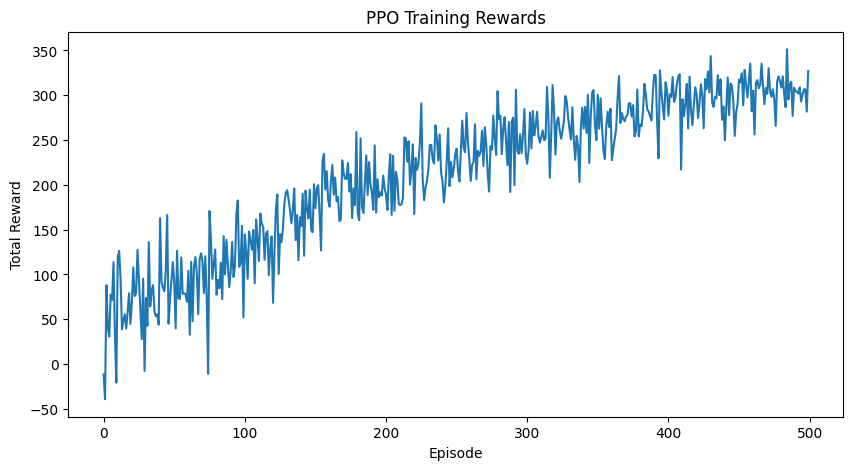

Date: 2022-01-03,  Action: Hold,  Price: 182.01,  Balance: 10000.00,  Shares: 0,  Equity: 10000.00,  Position: 0
Date: 2022-01-04,  Action: Hold,  Price: 179.70,  Balance: 10000.00,  Shares: 0,  Equity: 10000.00,  Position: 0
Date: 2022-01-05,  Action: Buy,  Price: 174.92,  Balance: 10000.00,  Shares: 0,  Equity: 10000.00,  Position: 0
Date: 2022-01-06,  Action: Buy,  Price: 172.00,  Balance: 9828.00,  Shares: 1,  Equity: 10000.00,  Position: 1
Date: 2022-01-07,  Action: Buy,  Price: 172.17,  Balance: 9828.00,  Shares: 1,  Equity: 10000.17,  Position: 1
Date: 2022-01-10,  Action: Buy,  Price: 172.19,  Balance: 9828.00,  Shares: 1,  Equity: 10000.19,  Position: 1
Date: 2022-01-11,  Action: Buy,  Price: 175.08,  Balance: 9828.00,  Shares: 1,  Equity: 10003.08,  Position: 1
Date: 2022-01-12,  Action: Buy,  Price: 175.53,  Balance: 9828.00,  Shares: 1,  Equity: 10003.53,  Position: 1
Date: 2022-01-13,  Action: Buy,  Price: 172.19,  Balance: 9828.00,  Shares: 1,  Equity: 10000.19,  Position

In [5]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
from gym import spaces


# Set random seeds for reproducibility
auto_seed = 42
np.random.seed(auto_seed)
torch.manual_seed(auto_seed)


# =============================================================================
# 1. Trading Environment Including Standardization, Sentiment Score, Forecast
# =============================================================================
class TradingEnv(gym.Env):
   """
   A custom trading environment that includes:
     - sentiment score,
     - forecasted price,
     - standard ATR stop-loss,
     - z-score standardization of features.


   Expected CSV columns:
     - Date, High, Low, Price (close), MA5, MA20, RSI, MACD,
       sentiment_score, Forecasted_Price


   State vector (length = n_features + 1):
     [z(Price), z(MA5), z(MA20), z(RSI), z(MACD),
      z(sentiment_score), z(Forecasted_Price), Position]
   where Position is 0 or 1.


   Actions:
     0 = Hold, 1 = Buy, 2 = Sell
   """
   metadata = {'render.modes': ['human']}


   def __init__(self,
                data_path="/Users/User/Desktop/DIA/FinancialTradingBot/Merged_Data_For_RL/"
                          "AAPL_stock_data_2022-01-01_to_2024-12-31.csv",
                initial_balance=10000,
                stop_loss_multiplier=2,
                window=5):
       super(TradingEnv, self).__init__()
       # 1) Load data and parse dates
       self.data = pd.read_csv(data_path)
       self.data.rename(columns={
            "Close": "Price",
            "Sentiment_Score": "sentiment_score",
            "Predicted_Next_Close": "Forecasted_Price"
        }, inplace=True)

       self.data["Date"] = pd.to_datetime(self.data["Date"])
       self.num_data = len(self.data)


       # 2) Portfolio params
       self.initial_balance      = initial_balance
       self.stop_loss_multiplier = stop_loss_multiplier
       self.window               = window


       # 3) Compute z-score stats for features
       feature_cols = [
           "Price", "MA5", "MA20",
           "RSI", "MACD",
           "sentiment_score", "Forecasted_Price"
       ]
       self.feature_cols  = feature_cols
       self.feature_mean  = self.data[feature_cols].mean()
       self.feature_std   = self.data[feature_cols].std()


       # 4) Action & Observation spaces
       self.action_space = spaces.Discrete(3)  # 0=Hold,1=Buy,2=Sell
       state_dim = len(feature_cols) + 1       # +1 for Position
       self.observation_space = spaces.Box(
           low=-np.inf,
           high=np.inf,
           shape=(state_dim,),
           dtype=np.float32
       )


       # 5) Initialize state
       _ = self.reset()


   def reset(self):
       """
       Resets portfolio and time pointer; returns first observation.
       """
       self.balance        = self.initial_balance
       self.shares         = 0
       self.position       = 0
       self.entry_price    = 0.0
       self.current_step   = 0
       self.done           = False
       self.equity_history = [self.initial_balance]
       return self._get_state()


   def _get_state(self):
       row = self.data.iloc[self.current_step]
       vals = (row[self.feature_cols] - self.feature_mean) / self.feature_std
       state = np.concatenate([vals.values, [self.position]])
       return state.astype(np.float32)


   def step(self, action):
       if self.done:
           raise RuntimeError("Episode has ended. Please reset().")


       prev_close  = self.data.loc[self.current_step, "Price"]
       prev_equity = self.balance + self.shares * prev_close


       # advance timestep
       self.current_step += 1
       if self.current_step >= self.num_data - 1:
           self.done = True


       current_close = self.data.loc[self.current_step, "Price"]


       # 1) Execute action
       if action == 1 and self.shares == 0 and self.balance >= current_close:
           self.shares      = 1
           self.position    = 1
           self.entry_price = current_close
           self.balance    -= current_close
       elif action == 2 and self.shares > 0:
           self.balance    += current_close * self.shares
           self.shares      = 0
           self.position    = 0
           self.entry_price = 0.0


       # 2) Standard ATR stop-loss
       if self.shares > 0:
           trs = []
           start = max(1, self.current_step - self.window + 1)
           for i in range(start, self.current_step + 1):
               hi = self.data.loc[i,   "High"]
               lo = self.data.loc[i,   "Low"]
               prev_c = self.data.loc[i-1, "Price"]
               tr = max(hi - lo,
                        abs(hi - prev_c),
                        abs(lo - prev_c))
               trs.append(tr)
           atr = np.mean(trs) if trs else 0.0
           if current_close < self.entry_price - self.stop_loss_multiplier * atr:
               # force liquidate
               self.balance    += current_close * self.shares
               self.shares      = 0
               self.position    = 0
               self.entry_price = 0.0


       # 3) Reward = equity delta
       equity = self.balance + self.shares * current_close
       reward = equity - prev_equity
       self.equity_history.append(equity)


       return self._get_state(), reward, self.done, {}


   def render(self, action=None, mode='human'):
       """
       Prints the current trading date, action taken, price and portfolio state.
       """
       row      = self.data.iloc[self.current_step]
       date_str = row["Date"].strftime("%Y-%m-%d")
       price    = row["Price"]
       equity   = self.balance + self.shares * price
       action_str = {0: 'Hold', 1: 'Buy', 2: 'Sell'}.get(action, 'N/A')


       print(f"Date: {date_str},  "
             f"Action: {action_str},  "
             f"Price: {price:.2f},  "
             f"Balance: {self.balance:.2f},  "
             f"Shares: {self.shares},  "
             f"Equity: {equity:.2f},  "
             f"Position: {self.position}")




# =============================================================================
# 2. PPO Actor-Critic Network
# =============================================================================
class ActorCritic(nn.Module):
   def __init__(self, input_dim, action_dim, hidden_dim=64):
       super().__init__()
       self.shared = nn.Sequential(
           nn.Linear(input_dim, hidden_dim),
           nn.ReLU()
       )
       self.actor = nn.Sequential(
           nn.Linear(hidden_dim, hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, action_dim),
           nn.Softmax(dim=-1)
       )
       self.critic = nn.Sequential(
           nn.Linear(hidden_dim, hidden_dim),
           nn.ReLU(),
           nn.Linear(hidden_dim, 1)
       )


   def forward(self, x):
       h = self.shared(x)
       return self.actor(h), self.critic(h)




# =============================================================================
# 3. PPO Agent
# =============================================================================
class PPOAgent:
   def __init__(self, input_dim, action_dim,
                hidden_dim=64, lr=3e-4,
                gamma=0.99, lam=0.95,
                clip_epsilon=0.2,
                update_epochs=10,
                batch_size=64):
       self.gamma = gamma
       self.lam = lam
       self.clip_epsilon = clip_epsilon
       self.update_epochs = update_epochs
       self.batch_size = batch_size


       self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
       self.model = ActorCritic(input_dim, action_dim, hidden_dim).to(self.device)
       self.optimizer = optim.Adam(self.model.parameters(), lr=lr)


   def select_action(self, state):
       s = torch.FloatTensor(state).to(self.device)
       probs, val = self.model(s)
       dist = torch.distributions.Categorical(probs)
       a = dist.sample()
       return a.item(), dist.log_prob(a).item(), val.item()


   def compute_gae(self, rewards, values, dones):
       advantages = []
       gae = 0
       values = values + [0]
       for t in reversed(range(len(rewards))):
           delta = rewards[t] + self.gamma * (1 - dones[t]) * values[t+1] - values[t]
           gae = delta + self.gamma * self.lam * (1 - dones[t]) * gae
           advantages.insert(0, gae)
       returns = [adv + v for adv, v in zip(advantages, values[:-1])]
       return advantages, returns


   def update(self, traj):
       states      = torch.FloatTensor(traj['states']).to(self.device)
       actions     = torch.LongTensor(traj['actions']).to(self.device)
       old_logprobs= torch.FloatTensor(traj['log_probs']).to(self.device)
       rewards     = traj['rewards']
       dones       = traj['dones']
       values      = traj['values']


       advs, rets = self.compute_gae(rewards, values, dones)
       advs = torch.FloatTensor(advs).to(self.device)
       rets = torch.FloatTensor(rets).to(self.device)
       advs = (advs - advs.mean()) / (advs.std() + 1e-8)


       dataset_size = states.size(0)
       for _ in range(self.update_epochs):
           perm = torch.randperm(dataset_size)
           for i in range(0, dataset_size, self.batch_size):
               idx = perm[i:i+self.batch_size]
               bs, ba, blp, ba_adv, br = (
                   states[idx], actions[idx], old_logprobs[idx], advs[idx], rets[idx]
               )
               probs, vals = self.model(bs)
               dist = torch.distributions.Categorical(probs)
               lp   = dist.log_prob(ba)
               ent  = dist.entropy().mean()


               ratio = torch.exp(lp - blp)
               s1    = ratio * ba_adv
               s2    = torch.clamp(ratio, 1 - self.clip_epsilon, 1 + self.clip_epsilon) * ba_adv
               actor_loss = -torch.min(s1, s2).mean()
               critic_loss= nn.MSELoss()(vals.squeeze(-1), br)
               loss       = actor_loss + 0.5 * critic_loss - 0.01 * ent


               self.optimizer.zero_grad()
               loss.backward()
               self.optimizer.step()




# =============================================================================
# 4. PPO Training Loop
# =============================================================================
def train_ppo(env, agent, num_episodes=500, rollout_length=None):
   rewards_hist = []
   rollout_length = rollout_length or env.num_data
   for ep in range(num_episodes):
       state = env.reset()
       traj = {'states': [], 'actions': [], 'log_probs': [], 'rewards': [], 'dones': [], 'values': []}
       total, done = 0, False
       for _ in range(rollout_length):
           a, lp, v = agent.select_action(state)
           ns, r, done, _ = env.step(a)
           traj['states'].append(state)
           traj['actions'].append(a)
           traj['log_probs'].append(lp)
           traj['rewards'].append(r)
           traj['dones'].append(float(done))
           traj['values'].append(v)
           state = ns
           total += r
           if done:
               break
       agent.update(traj)
       rewards_hist.append(total)
       if (ep+1) % 50 == 0:
           print(f"Episode {ep+1}/{num_episodes} — Reward {total:.2f}")
   return rewards_hist




# =============================================================================
# 5. Performance Metrics
# =============================================================================
def compute_performance_metrics(equity_history, risk_free_rate=0.0):
   e = np.array(equity_history)
   roi = (e[-1] - e[0]) / e[0]
   dr = np.diff(e) / e[:-1]
   mu, sigma = dr.mean(), dr.std()
   sr = ((mu - risk_free_rate) / sigma * np.sqrt(252)) if sigma > 0 else 0.0
   peak, maxdd = e[0], 0
   for x in e:
       peak = max(peak, x)
       dd = (peak - x) / peak
       maxdd = max(maxdd, dd)
   return roi, sr, maxdd




# =============================================================================
# 6. Main: Train, Eval, and Plot with date printing
# =============================================================================
if __name__ == "__main__":
   env = TradingEnv(
       data_path="/Users/wongyule/Documents/Designing Intelligent Agents/FinancialTradingBot/Merged_Data_For_RL/AAPL_stock_data_2022-01-01_to_2024-12-31.csv"
   )
   state_dim  = env.observation_space.shape[0]
   action_dim = env.action_space.n
   agent      = PPOAgent(input_dim=state_dim, action_dim=action_dim)


   # training
   rewards = train_ppo(env, agent, num_episodes=500, rollout_length=env.num_data)


   # plot training curve
   plt.figure(figsize=(10,5))
   plt.plot(rewards)
   plt.xlabel("Episode")
   plt.ylabel("Total Reward")
   plt.title("PPO Training Rewards")
   plt.show()


   # evaluation (prints Date rather than Step)
   state, done = env.reset(), False
   while not done:
       a, _, _ = agent.select_action(state)
       env.render(action=a)
       state, _, done, _ = env.step(a)


   # final metrics
   roi, sharpe, maxdd = compute_performance_metrics(env.equity_history)
   print(f"ROI: {roi*100:.2f}%")
   print(f"Sharpe: {sharpe:.2f}")
   print(f"Max Drawdown: {maxdd*100:.2f}%")

